In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles, return_all=False):
        outputs = []

        # 原始 forward 到最后一个隐藏层
        for i in range(self.depth - 1):
            x = self.layers[i * 2](x)
            x = self.layers[i * 2 + 1](x)
        if return_all:
            outputs.append(x.clone())

        # 重复循环 hidden 部分
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1):  # 从第一个隐藏层开始传递
                x = self.layers[i * 2](x)
                x = self.layers[i * 2 + 1](x)
            if return_all:
                outputs.append(x.clone())

        if return_all:
            return torch.stack(outputs, dim=1)  # shape: [batch, cycles, hidden_dim]
        else:
            return x


In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles, return_all=False):
        x = torch.tensor(x, requires_grad=True).float().to(device)
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles, return_all=return_all)
        
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output


In [5]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [6]:
import pickle

# 定义保存模型的文件路径
model_path = 'LDP.pkl'

# 从文件中读取模型
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# 现在 model 变量中包含了读取的模型对象

In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态




# up = 80000
n_star = 500+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
y_pred, _ = model.predict(x_star)
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
y_pred = get_system_performance(y_pred_df)
# y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_star = eigenvector_solution_df


#计算误差（基于2范数）        
np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2) #计算误差，然后将误差添加到error_u列表中             
# 计算 MAE 和 MSE






0.0029592423433424547

In [9]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.976379  0.006006  0.008452  0.008936  0.000065  0.000062  0.000077   
1  0.967045  0.008355  0.011918  0.012258  0.000113  0.000117  0.000147   
2  0.958036  0.010629  0.015261  0.015401  0.000174  0.000185  0.000239   
3  0.949459  0.012777  0.018462  0.018336  0.000244  0.000259  0.000348   
4  0.941321  0.014791  0.021506  0.021084  0.000326  0.000339  0.000472   

    state_8       state_9      state_10      state_11      state_12  
0  0.000023  2.983647e-07  7.601000e-08  1.336332e-07  2.114727e-08  
1  0.000044  9.325159e-07  2.507283e-07  4.161268e-07  5.205637e-08  
2  0.000072  2.179579e-06  6.222484e-07  1.008672e-06  1.081848e-07  
3  0.000107  4.113634e-06  1.244951e-06  1.979137e-06  1.925196e-07  
4  0.000148  6.799867e-06  2.171690e-06  3.379340e-06  3.071241e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757668  0.053083  0.094788  0.068945  0.00663

In [10]:
y_pred_LDP = y_pred_df.copy()
print(y_pred_LDP.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.976379  0.006006  0.008452  0.008936  0.000065  0.000062  0.000077   
1  0.967045  0.008355  0.011918  0.012258  0.000113  0.000117  0.000147   
2  0.958036  0.010629  0.015261  0.015401  0.000174  0.000185  0.000239   
3  0.949459  0.012777  0.018462  0.018336  0.000244  0.000259  0.000348   
4  0.941321  0.014791  0.021506  0.021084  0.000326  0.000339  0.000472   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000023  2.983647e-07  7.601000e-08  1.336332e-07  2.114727e-08   
1  0.000044  9.325159e-07  2.507283e-07  4.161268e-07  5.205637e-08   
2  0.000072  2.179579e-06  6.222484e-07  1.008672e-06  1.081848e-07   
3  0.000107  4.113634e-06  1.244951e-06  1.979137e-06  1.925196e-07   
4  0.000148  6.799867e-06  2.171690e-06  3.379340e-06  3.071241e-07   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.976379    0.006006    0.008999    0.008528  0.000089 

/tmp/ipykernel_1564519/481991613.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


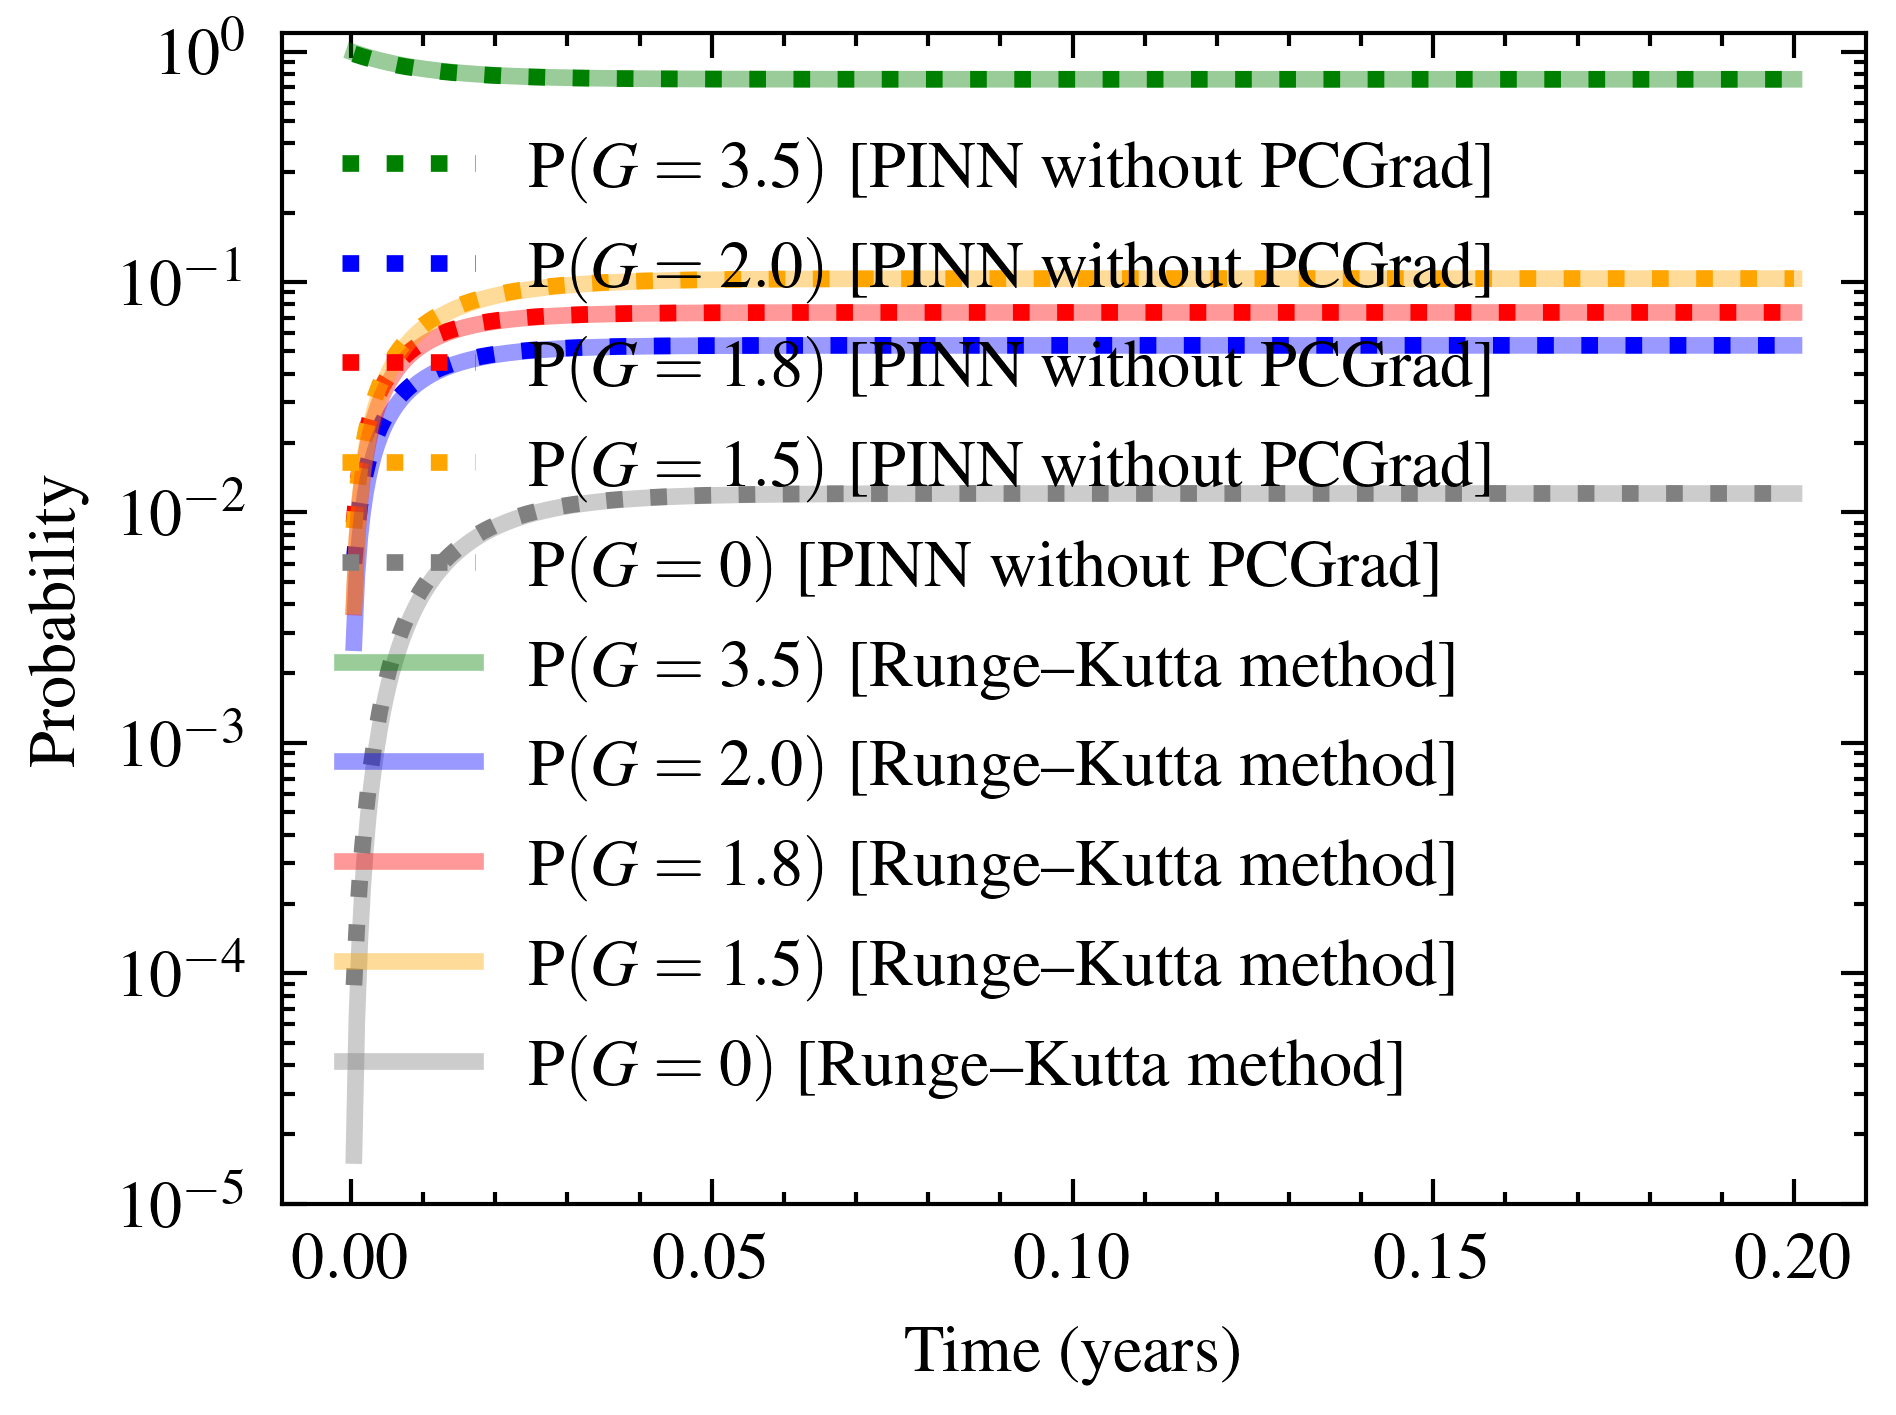

In [11]:
# 应用 science + ieee 样式
import scienceplots
plt.style.use(['science', 'ieee'])

f, ax = plt.subplots(1, 1)

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 2, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 2)



ax.legend(ncol=2)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'))
ax.set_ylabel("Probability", fontdict=dict(weight='bold'))

# 图例 & 布局优化
ax.legend()
plt.tight_layout()

# 保存图像
# plt.savefig('LDP_MSS3.png', dpi=300, bbox_inches='tight')

plt.tight_layout()

In [12]:
# 定义保存模型的文件路径
model_path = 'NAP.pkl'

# 从文件中读取模型
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# 现在 model 变量中包含了读取的模型对象

In [13]:

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态




# up = 80000
n_star = 500+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
y_pred, _ = model.predict(x_star)
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
y_pred = get_system_performance(y_pred_df)
# y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_star = eigenvector_solution_df


#计算误差（基于2范数）        
np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2) #计算误差，然后将误差添加到error_u列表中             
# 计算 MAE 和 MSE






0.003666558382143215

In [14]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.973651  0.006945  0.009426  0.009682  0.000073  0.000072  0.000114   
1  0.963812  0.009408  0.013075  0.013153  0.000136  0.000137  0.000208   
2  0.954800  0.011636  0.016419  0.016288  0.000211  0.000213  0.000319   
3  0.946444  0.013681  0.019524  0.019154  0.000297  0.000297  0.000441   
4  0.938516  0.015604  0.022476  0.021834  0.000391  0.000388  0.000574   

    state_8   state_9      state_10      state_11      state_12  
0  0.000035  0.000001  4.310848e-07  4.270515e-07  4.861323e-08  
1  0.000066  0.000003  9.802301e-07  1.044705e-06  1.048121e-07  
2  0.000104  0.000005  1.779992e-06  1.997897e-06  1.852524e-07  
3  0.000147  0.000009  2.828089e-06  3.300956e-06  2.910840e-07  
4  0.000195  0.000012  4.140471e-06  4.988176e-06  4.252297e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757789  0.053048  0.094724  0.068908  0.006634  0.004829  0.008621   

In [15]:
y_pred_NAP = y_pred_df.copy()
print(y_pred_NAP.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.973651  0.006945  0.009426  0.009682  0.000073  0.000072  0.000114   
1  0.963812  0.009408  0.013075  0.013153  0.000136  0.000137  0.000208   
2  0.954800  0.011636  0.016419  0.016288  0.000211  0.000213  0.000319   
3  0.946444  0.013681  0.019524  0.019154  0.000297  0.000297  0.000441   
4  0.938516  0.015604  0.022476  0.021834  0.000391  0.000388  0.000574   

    state_8   state_9      state_10      state_11      state_12  system_3.5  \
0  0.000035  0.000001  4.310848e-07  4.270515e-07  4.861323e-08    0.973651   
1  0.000066  0.000003  9.802301e-07  1.044705e-06  1.048121e-07    0.963812   
2  0.000104  0.000005  1.779992e-06  1.997897e-06  1.852524e-07    0.954800   
3  0.000147  0.000009  2.828089e-06  3.300956e-06  2.910840e-07    0.946444   
4  0.000195  0.000012  4.140471e-06  4.988176e-06  4.252297e-07    0.938516   

   system_2.0  system_1.8  system_1.5  system_0  
0    0.006945    0.00975

/tmp/ipykernel_1564519/481991613.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


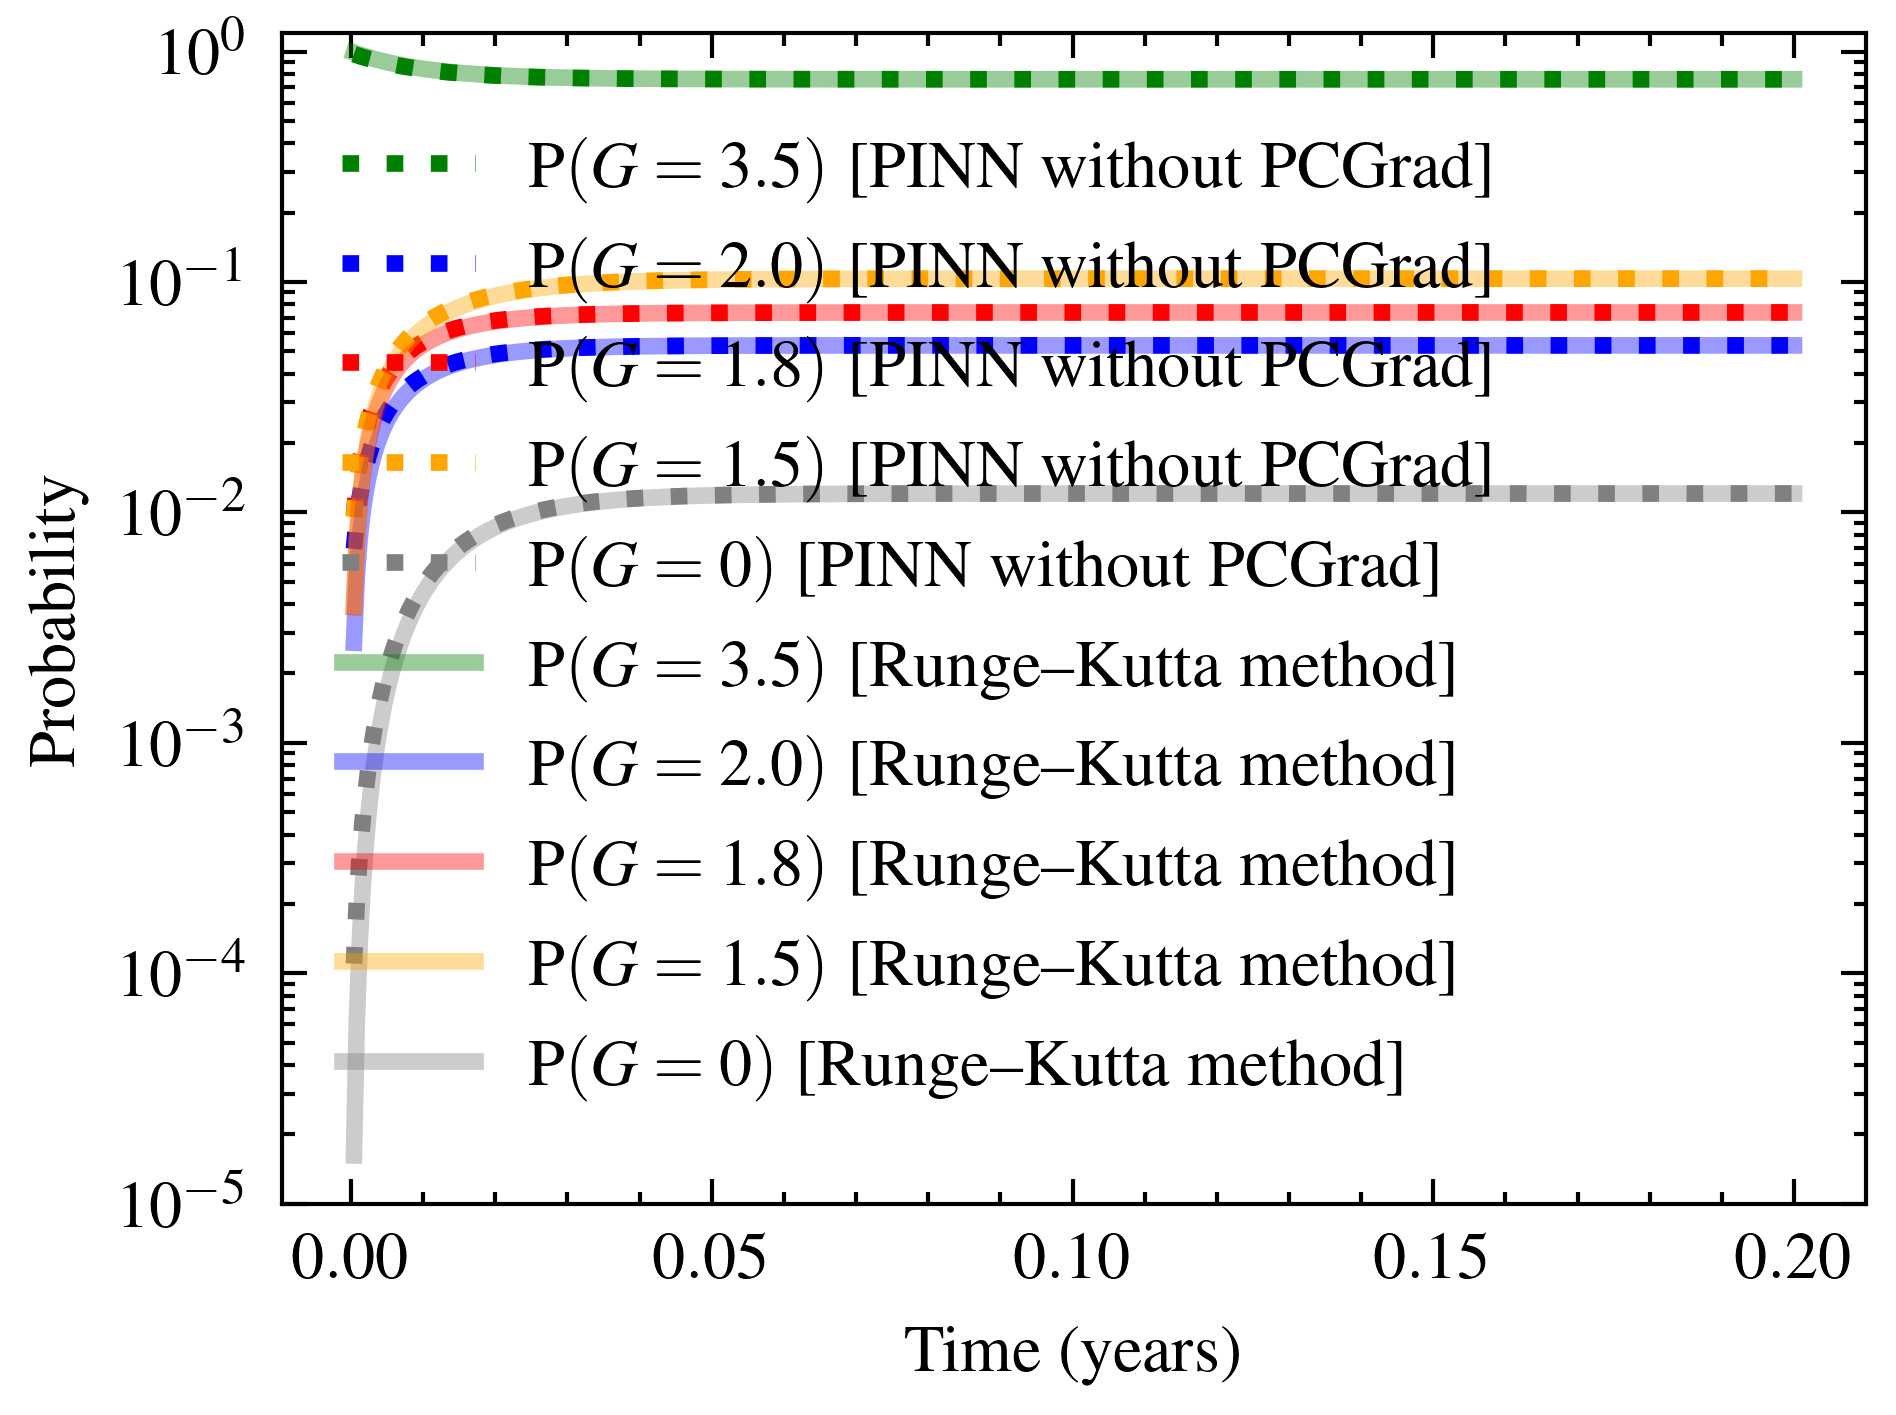

In [16]:
# 应用 science + ieee 样式
import scienceplots
plt.style.use(['science', 'ieee'])

f, ax = plt.subplots(1, 1)

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 2, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 2)



ax.legend(ncol=2)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'))
ax.set_ylabel("Probability", fontdict=dict(weight='bold'))

# 图例 & 布局优化
ax.legend()
plt.tight_layout()

# 保存图像
# plt.savefig('LDP_MSS3.png', dpi=300, bbox_inches='tight')

plt.tight_layout()

In [17]:
#RSP没有与均值接近的seed

In [18]:
# 定义保存模型的文件路径
model_path = 'RSP.pkl'

# 从文件中读取模型
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# 现在 model 变量中包含了读取的模型对象

In [19]:

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态




# up = 80000
n_star = 500+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
y_pred, _ = model.predict(x_star)
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
y_pred = get_system_performance(y_pred_df)
# y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_star = eigenvector_solution_df


#计算误差（基于2范数）        
np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2) #计算误差，然后将误差添加到error_u列表中             
# 计算 MAE 和 MSE






0.002347580924822017

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.978871  0.005561  0.007505  0.007829  0.000054  0.000058  0.000083   
1  0.969342  0.007968  0.011048  0.011213  0.000103  0.000107  0.000150   
2  0.960250  0.010255  0.014430  0.014399  0.000164  0.000166  0.000232   
3  0.951589  0.012413  0.017654  0.017397  0.000237  0.000235  0.000330   
4  0.943343  0.014444  0.020728  0.020215  0.000320  0.000313  0.000444   

    state_8   state_9  state_10  state_11      state_12  
0  0.000035  0.000002  0.000001  0.000001  6.596105e-08  
1  0.000062  0.000003  0.000001  0.000002  8.367692e-08  
2  0.000095  0.000005  0.000002  0.000003  1.053776e-07  
3  0.000132  0.000007  0.000003  0.000004  1.340247e-07  
4  0.000175  0.000009  0.000004  0.000005  1.720031e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757858  0.053032  0.094754  0.068886  0.006626  0.004812  0.008598   
496  0.757858  0.053032  0.094754  0.068886  0.

In [21]:
y_pred_RSP = y_pred_df.copy()
print(y_pred_RSP.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.978871  0.005561  0.007505  0.007829  0.000054  0.000058  0.000083   
1  0.969342  0.007968  0.011048  0.011213  0.000103  0.000107  0.000150   
2  0.960250  0.010255  0.014430  0.014399  0.000164  0.000166  0.000232   
3  0.951589  0.012413  0.017654  0.017397  0.000237  0.000235  0.000330   
4  0.943343  0.014444  0.020728  0.020215  0.000320  0.000313  0.000444   

    state_8   state_9  state_10  state_11      state_12  system_3.5  \
0  0.000035  0.000002  0.000001  0.000001  6.596105e-08    0.978871   
1  0.000062  0.000003  0.000001  0.000002  8.367692e-08    0.969342   
2  0.000095  0.000005  0.000002  0.000003  1.053776e-07    0.960250   
3  0.000132  0.000007  0.000003  0.000004  1.340247e-07    0.951589   
4  0.000175  0.000009  0.000004  0.000005  1.720031e-07    0.943343   

   system_2.0  system_1.8  system_1.5  system_0  
0    0.005561    0.007886    0.007588  0.000094  
1    0.007968    0.011

/tmp/ipykernel_1564519/481991613.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


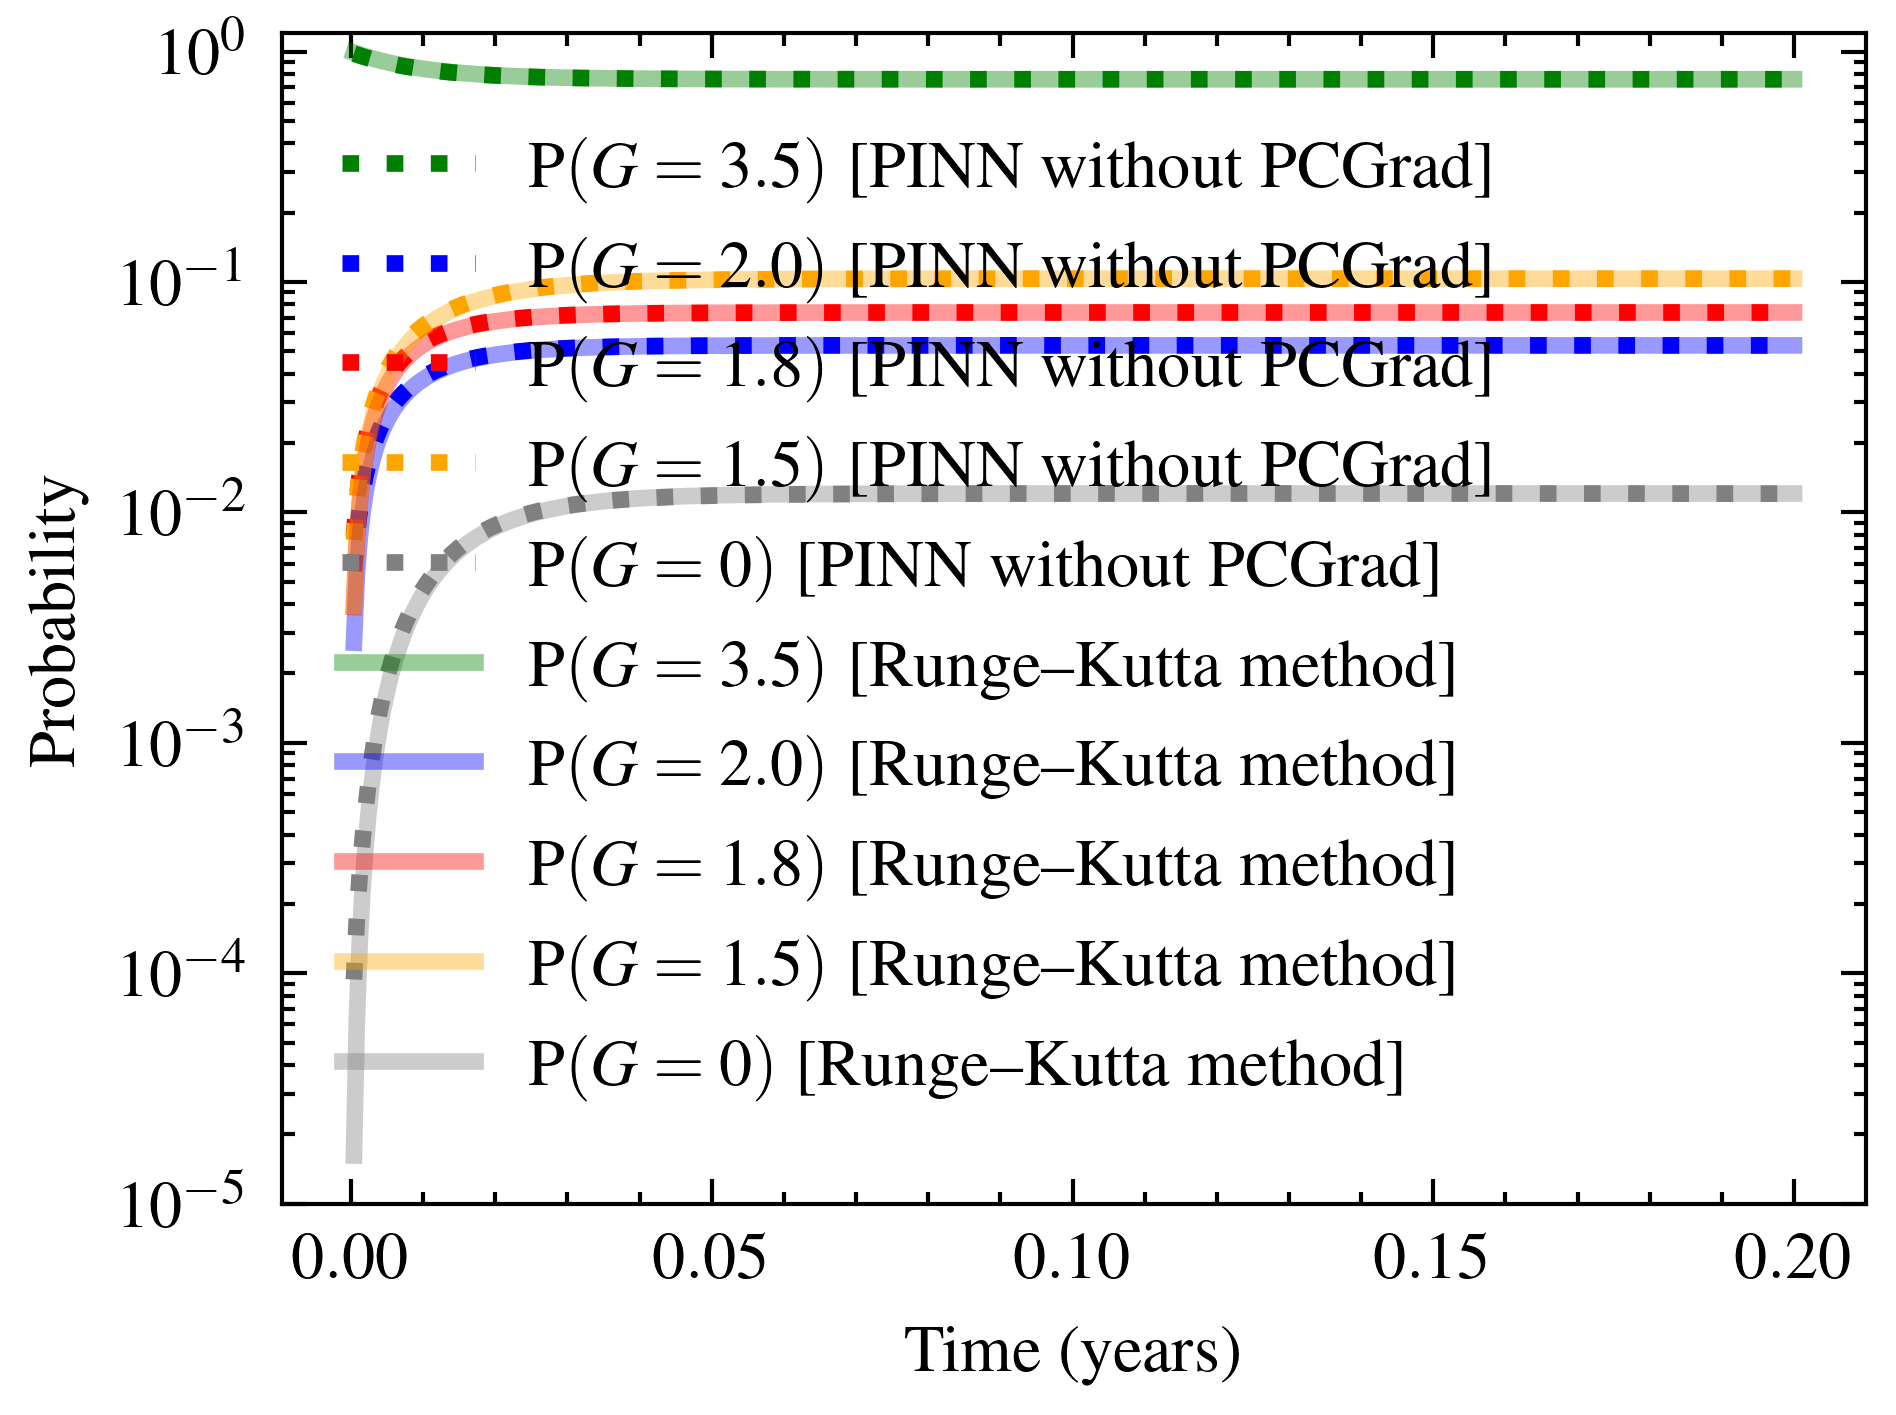

In [22]:
# 应用 science + ieee 样式
import scienceplots
plt.style.use(['science', 'ieee'])

f, ax = plt.subplots(1, 1)

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 2, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 2)



ax.legend(ncol=2)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'))
ax.set_ylabel("Probability", fontdict=dict(weight='bold'))

# 图例 & 布局优化
ax.legend()
plt.tight_layout()

# 保存图像
# plt.savefig('LDP_MSS3.png', dpi=300, bbox_inches='tight')

plt.tight_layout()

In [23]:
# 定义保存模型的文件路径
model_path = 'RCP.pkl'

# 从文件中读取模型
with open(model_path, 'rb') as f:
    model = pickle.load(f)

# 现在 model 变量中包含了读取的模型对象


In [24]:

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态




# up = 80000
n_star = 500+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
y_pred, _ = model.predict(x_star)
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
y_pred = get_system_performance(y_pred_df)
# y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_star = eigenvector_solution_df


#计算误差（基于2范数）        
np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2) #计算误差，然后将误差添加到error_u列表中             
# 计算 MAE 和 MSE






0.001630195128457047

In [25]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.982041  0.004720  0.006561  0.006524  0.000037  0.000045  0.000052   
1  0.972362  0.007179  0.010152  0.009992  0.000080  0.000086  0.000109   
2  0.963149  0.009488  0.013575  0.013249  0.000138  0.000142  0.000190   
3  0.954360  0.011677  0.016831  0.016311  0.000210  0.000210  0.000291   
4  0.945978  0.013748  0.019936  0.019185  0.000295  0.000289  0.000410   

    state_8       state_9      state_10      state_11      state_12  
0  0.000019  4.901076e-07  2.814201e-07  2.846978e-07  6.840160e-08  
1  0.000037  1.037724e-06  5.497718e-07  6.043466e-07  9.122520e-08  
2  0.000065  2.062160e-06  1.029329e-06  1.206310e-06  1.312537e-07  
3  0.000102  3.740478e-06  1.777579e-06  2.192820e-06  1.862544e-07  
4  0.000146  6.174358e-06  2.818098e-06  3.621378e-06  2.546249e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757868  0.053034  0.094728  0.068877  0.00663

In [26]:
y_pred_RCP = y_pred_df.copy()
print(y_pred_RCP.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.982041  0.004720  0.006561  0.006524  0.000037  0.000045  0.000052   
1  0.972362  0.007179  0.010152  0.009992  0.000080  0.000086  0.000109   
2  0.963149  0.009488  0.013575  0.013249  0.000138  0.000142  0.000190   
3  0.954360  0.011677  0.016831  0.016311  0.000210  0.000210  0.000291   
4  0.945978  0.013748  0.019936  0.019185  0.000295  0.000289  0.000410   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000019  4.901076e-07  2.814201e-07  2.846978e-07  6.840160e-08   
1  0.000037  1.037724e-06  5.497718e-07  6.043466e-07  9.122520e-08   
2  0.000065  2.062160e-06  1.029329e-06  1.206310e-06  1.312537e-07   
3  0.000102  3.740478e-06  1.777579e-06  2.192820e-06  1.862544e-07   
4  0.000146  6.174358e-06  2.818098e-06  3.621378e-06  2.546249e-07   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.982041    0.004720    0.006569    0.006613  0.000057 

/tmp/ipykernel_1564519/481991613.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


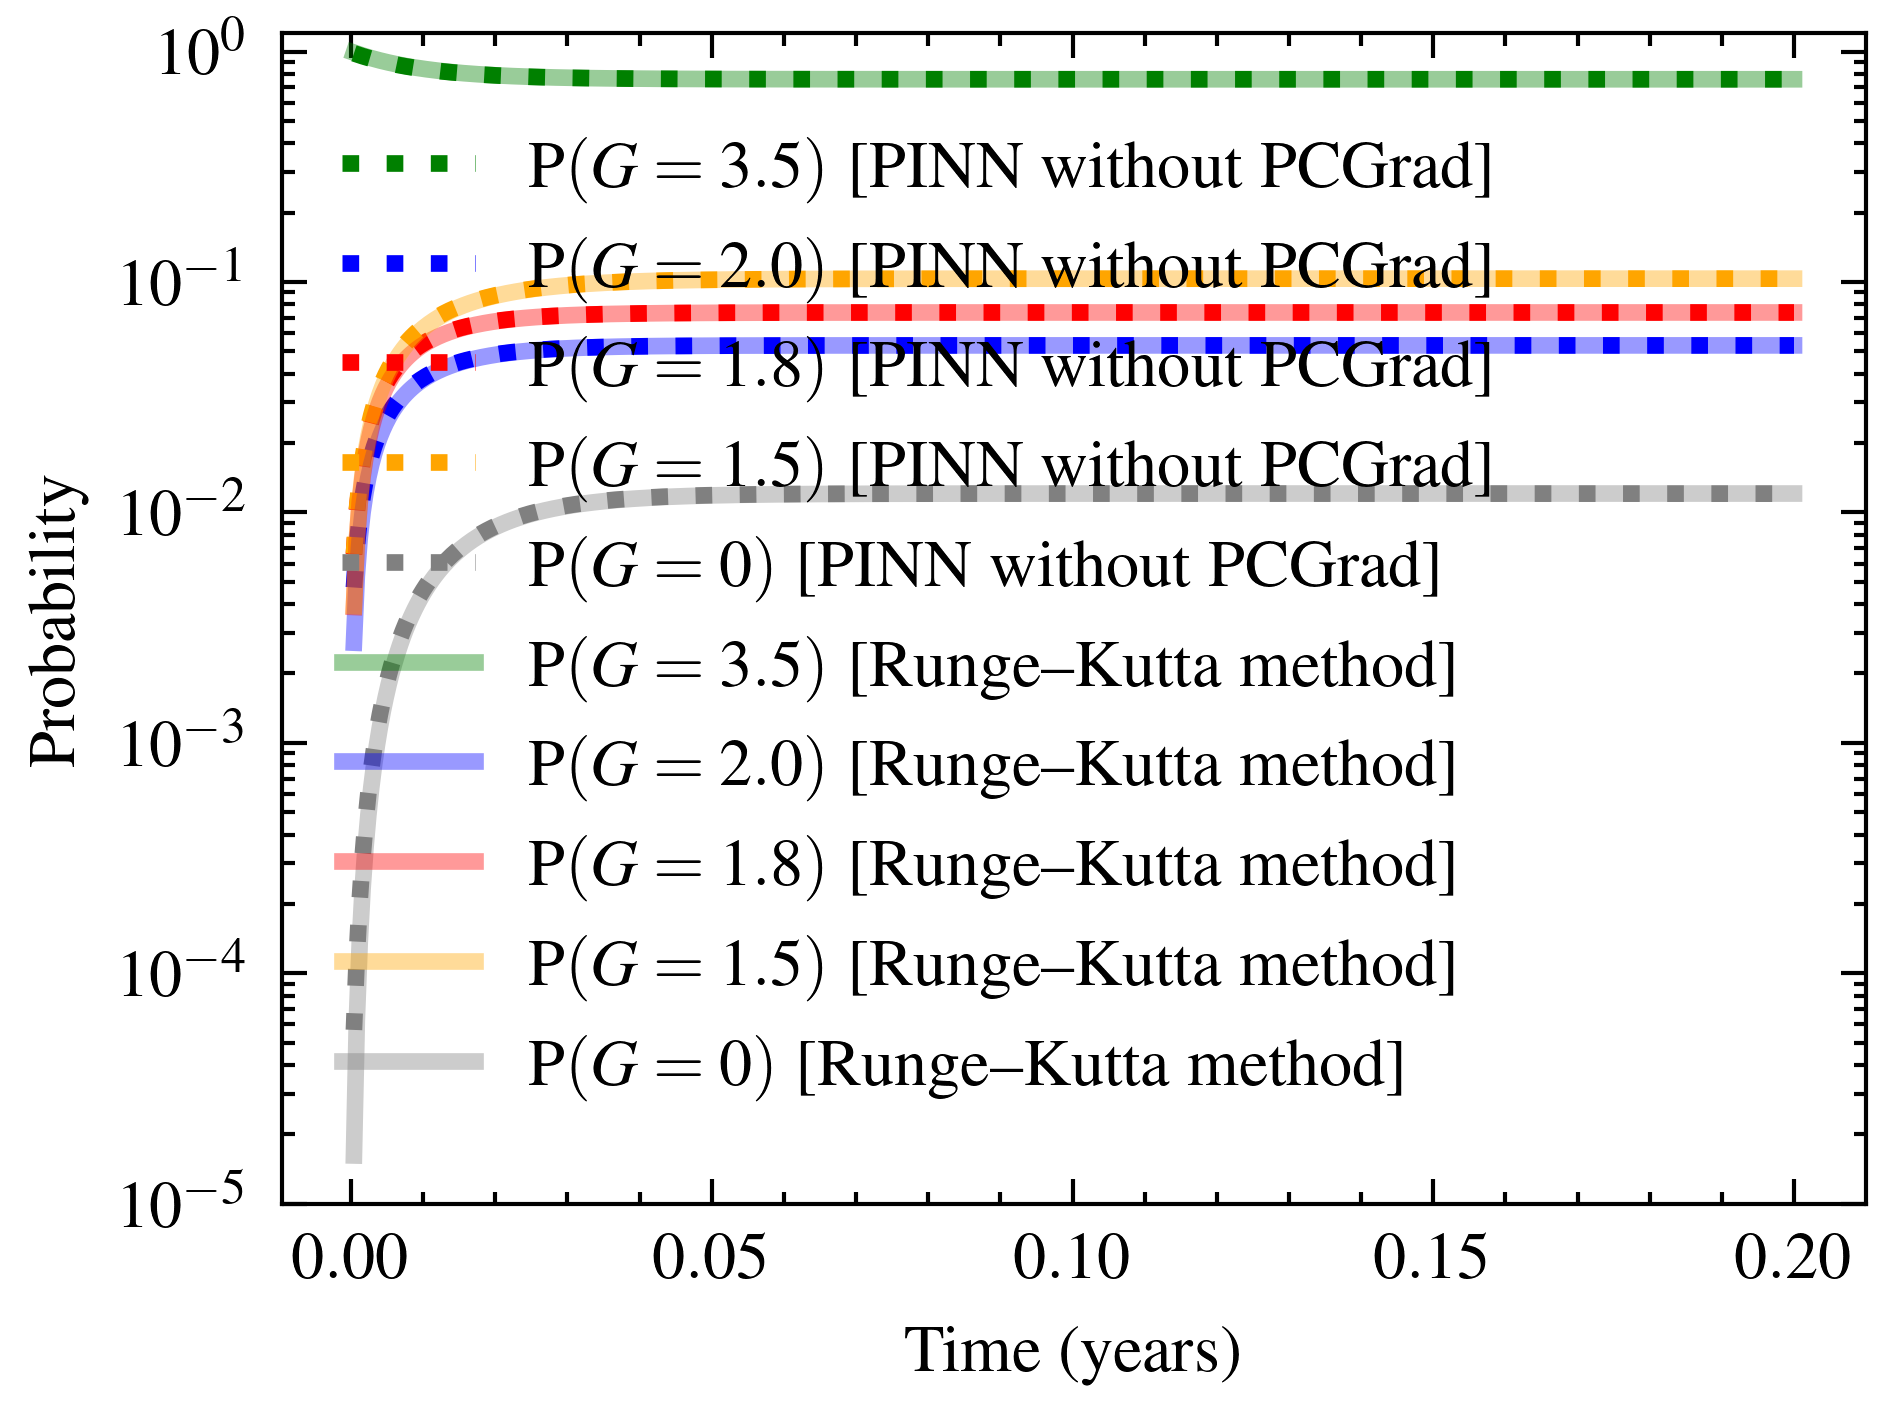

In [27]:
# 应用 science + ieee 样式
import scienceplots
plt.style.use(['science', 'ieee'])

f, ax = plt.subplots(1, 1)

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 2, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 2, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 2)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 2)



ax.legend(ncol=2)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'))
ax.set_ylabel("Probability", fontdict=dict(weight='bold'))

# 图例 & 布局优化
ax.legend()
plt.tight_layout()

# 保存图像
# plt.savefig('LDP_MSS3.png', dpi=300, bbox_inches='tight')

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


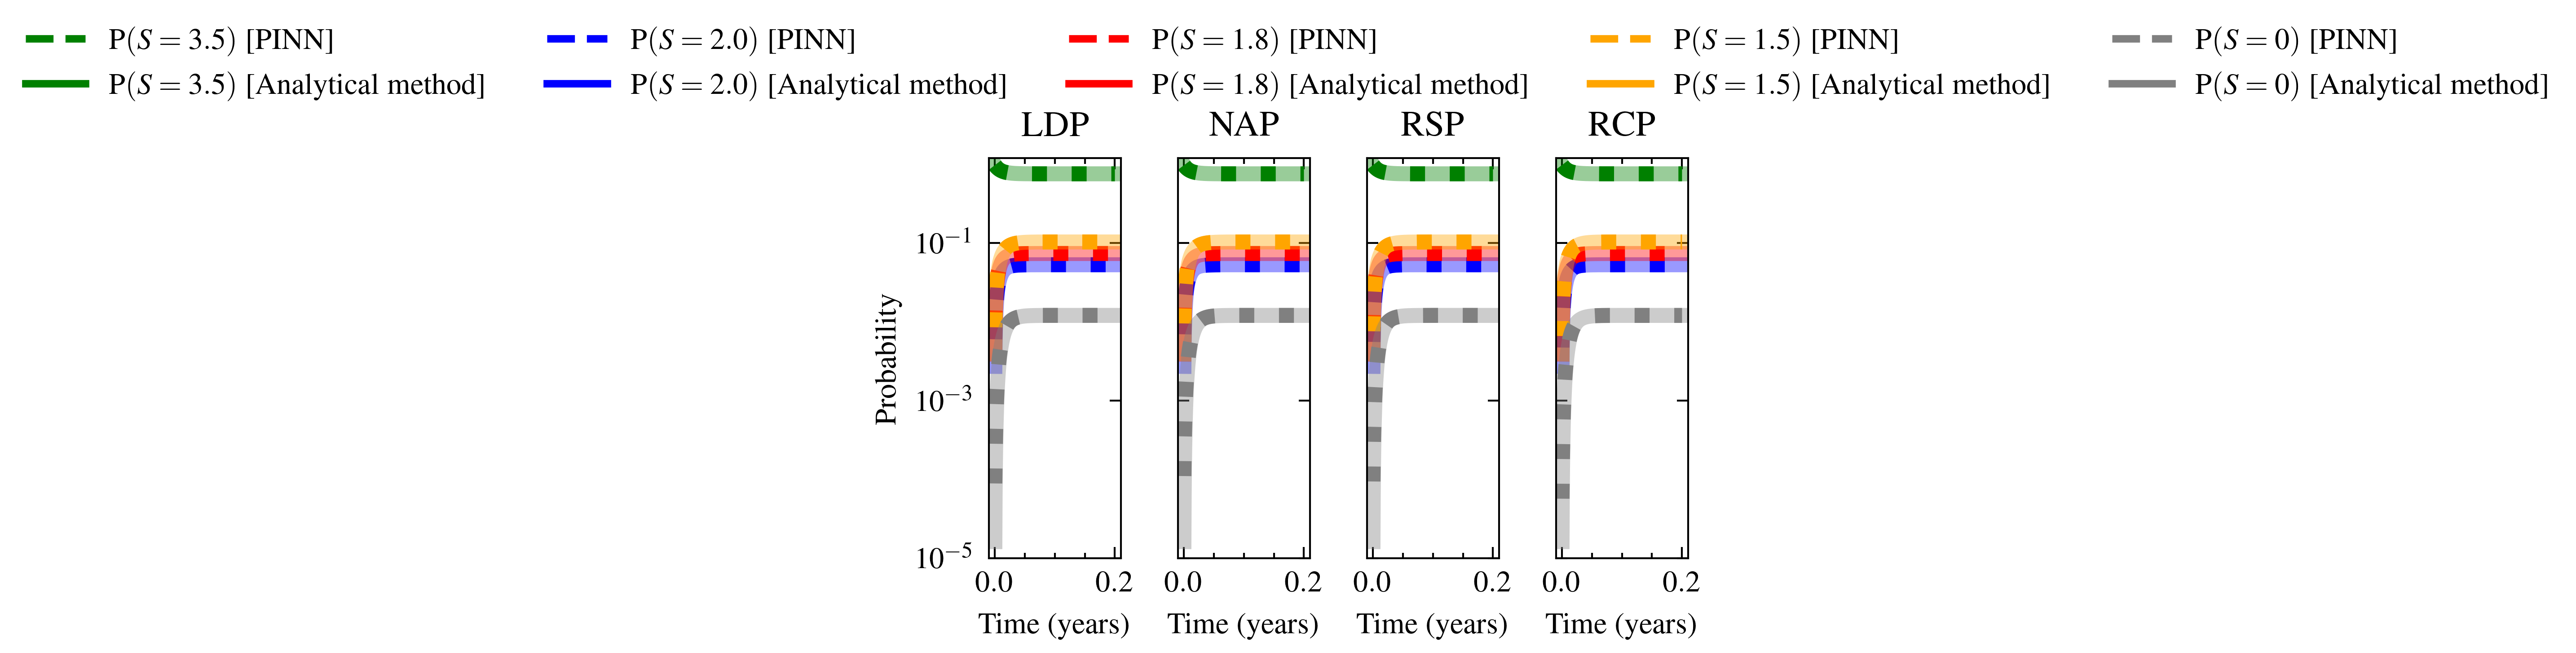

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from matplotlib.lines import Line2D

# 使用 science + ieee 样式
plt.style.use(['science', 'ieee'])


# 创建 1x4 子图
# fig, axs = plt.subplots(1, 4, figsize=(22, 10), sharey=True)
fig, axs = plt.subplots(1, 4, sharey=True)

# 数据输入（你需要事先准备好这些 DataFrame）
y_preds = [y_pred_LDP, y_pred_NAP, y_pred_RSP, y_pred_RCP]
titles = ['LDP', 'NAP', 'RSP', 'RCP']
colors = ['green', 'blue', 'red', 'orange', 'gray']
G_values = ['3.5', '2.0', '1.8', '1.5', '0']

# 主循环绘图（PINN 和 RK 曲线）
for i, (ax, y_pred, title) in enumerate(zip(axs, y_preds, titles)):
    for g, color in zip(G_values, colors):
        # PINN: 虚线
        sns.lineplot(
            x=x_star.flatten(),
            y=y_pred[f'system_{g}'],
            ax=ax,
            label=None,
            color=color,
            linestyle='dotted',
            linewidth=4
        )

        # RK: 实线
        sns.lineplot(
            x=x_star.flatten(),
            y=eigenvector_solution_df[f'system_{g}'],
            ax=ax,
            label=None,
            color=color,
            linestyle='-',
            linewidth=4,
            alpha = 0.4,
        )

    ax.set_title(title, fontweight='bold')
    ax.set_xlabel("Time (years)")
    if i == 0:
        ax.set_ylabel("Probability")
    ax.set_yscale("log")
    ax.set_ylim([1e-5, 1.2])
    ax.legend().remove()  # 禁用单图图例
    # ax.set_aspect(2)  # 调整宽高比（值越小，子图越“扁”）

# 构造统一图例（颜色表示 G，线型表示方法）
legend_handles = []
legend_labels = []

for g, color in zip(G_values, colors):
    # PINN 虚线
    legend_handles.append(Line2D([0], [0], color=color, linestyle='--', linewidth=2))
    legend_labels.append(rf'P$(S={g})$ [PINN]')

    # Runge–Kutta 实线
    legend_handles.append(Line2D([0], [0], color=color, linestyle='-', linewidth=2))
    legend_labels.append(rf'P$(S={g})$ [Analytical method]')

# 添加统一图例在顶部
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=5, frameon=False)

# 调整布局，留出图例空间
plt.tight_layout(rect=[0, 0, 1, 0.88])
# plt.tight_layout()

# 保存图像（可选）
plt.savefig("MSS3_result_kexue.pdf", dpi=300, bbox_inches="tight")

# 显示图像
plt.show()




In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from matplotlib.lines import Line2D

# 使用 science + ieee 样式
plt.style.use(['science', 'ieee'])

plt.rcParams['xtick.labelsize'] = 35  # x 轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 35  # y 轴刻度标签字体大小

# 创建 1x4 子图
fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharey=True)
# fig, axs = plt.subplots(1, 4, sharey=True)

# 数据输入（你需要事先准备好这些 DataFrame）
y_preds = [y_pred_LDP, y_pred_NAP, y_pred_RSP, y_pred_RCP]
titles = ['(a) NAL', '(b) RSCP', '(c) RCS', '(d) Proposed']
colors = ['#7179ad', '#007978', '#42a5a1', '#b6d2d0', '#1E90C1']
G_values = ['3.5', '2.0', '1.8', '1.5', '0']

# 主循环绘图（PINN 和 RK 曲线）
for i, (ax, y_pred, title) in enumerate(zip(axs, y_preds, titles)):
    for g, color in zip(G_values, colors):
        # PINN: 虚线
        sns.lineplot(
            x=x_star.flatten(),
            y=y_pred[f'system_{g}'],
            ax=ax,
            label=None,
            color=color,
            linestyle='dotted',
            linewidth=6
        )

        # RK: 实线
        sns.lineplot(
            x=x_star.flatten(),
            y=eigenvector_solution_df[f'system_{g}'],
            ax=ax,
            label=None,
            color=color,
            linestyle='-',
            linewidth=6,
            alpha = 0.4,
        )

    # ax.set_title(title, fontweight='bold', fontsize=45)
    # 在子图下方加标题（作为"下标题"）
    ax.text(0.5, -0.25, title, transform=ax.transAxes, ha='center', va='center',
            fontsize=45, fontweight='bold')

    ax.set_xlabel("Time (years)", fontsize=40)
    if i == 0:
        ax.set_ylabel("Probability", fontsize = 40)
    ax.set_yscale("log")
    ax.set_ylim([1e-5, 1.2])
    ax.legend().remove()  # 禁用单图图例
    # ax.set_aspect(2)  # 调整宽高比（值越小，子图越“扁”）

# 构造统一图例（颜色表示 G，线型表示方法）
legend_handles = []
legend_labels = []

for g, color in zip(G_values, colors):
    # PINN 虚线
    legend_handles.append(Line2D([0], [0], color=color, linestyle='--', linewidth=2))
    legend_labels.append(rf'P$(S={g})$ [PINN]')

    # Runge–Kutta 实线
    legend_handles.append(Line2D([0], [0], color=color, linestyle='-', linewidth=2))
    legend_labels.append(rf'P$(S={g})$ [Analytical method]')

# 添加统一图例在顶部
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=5, frameon=False, fontsize=30)

# 调整布局，留出图例空间
plt.tight_layout(rect=[0, 0, 1, 0.8])
# plt.tight_layout()

fig.subplots_adjust(wspace=0.1)  # ✅ 正确做法

# 保存图像（可选）
plt.savefig("MSS3_result.pdf", dpi=300, bbox_inches="tight")

# 显示图像
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from matplotlib.lines import Line2D

# 使用 science + ieee 样式
plt.style.use(['science', 'ieee'])

plt.rcParams['xtick.labelsize'] = 35  # x 轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 35  # y 轴刻度标签字体大小

# 创建 1x4 子图
fig, axs = plt.subplots(1, 4, figsize=(40, 10), sharey=True)
# fig, axs = plt.subplots(1, 4, sharey=True)

# 数据输入（你需要事先准备好这些 DataFrame）
y_preds = [y_pred_LDP, y_pred_NAP, y_pred_RSP, y_pred_RCP]
titles = ['(a) NAL', '(b) RSCP', '(c) RCS', '(d) Proposed']
colors = ['#7179ad', '#007978', '#42a5a1', '#b6d2d0', '#1E90C1']
G_values = ['3.5', '2.0', '1.8', '1.5', '0']

# 主循环绘图（PINN 和 RK 曲线）
for i, (ax, y_pred, title) in enumerate(zip(axs, y_preds, titles)):
    for g, color in zip(G_values, colors):
        # PINN: 虚线
        sns.lineplot(
            x=x_star.flatten(),
            y=y_pred[f'system_{g}'],
            ax=ax,
            label=None,
            color=color,
            linestyle='dotted',
            linewidth=6
        )

        # RK: 实线
        sns.lineplot(
            x=x_star.flatten(),
            y=eigenvector_solution_df[f'system_{g}'],
            ax=ax,
            label=None,
            color=color,
            linestyle='-',
            linewidth=6,
            alpha = 0.4,
        )

    # ax.set_title(title, fontweight='bold', fontsize=45)
    # 在子图下方加标题（作为"下标题"）
    ax.text(0.5, -0.25, title, transform=ax.transAxes, ha='center', va='center',
            fontsize=45, fontweight='bold')

    ax.set_xlabel("Time (years)", fontsize=40)
    if i == 0:
        ax.set_ylabel("Probability", fontsize = 40)
    ax.set_yscale("log")
    ax.set_ylim([1e-5, 1e-1])
    ax.set_xlim([0, 0.015])
    ax.set_xticks([0.0025, 0.0075, 0.0125])
    ax.legend().remove()  # 禁用单图图例
    # ax.set_aspect(2)  # 调整宽高比（值越小，子图越“扁”）

# 构造统一图例（颜色表示 G，线型表示方法）
legend_handles = []
legend_labels = []

for g, color in zip(G_values, colors):
    # PINN 虚线
    legend_handles.append(Line2D([0], [0], color=color, linestyle='--', linewidth=2))
    legend_labels.append(rf'P$(S={g})$ [PINN]')

    # Runge–Kutta 实线
    legend_handles.append(Line2D([0], [0], color=color, linestyle='-', linewidth=2))
    legend_labels.append(rf'P$(S={g})$ [Analytical method]')

# 添加统一图例在顶部
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=5, frameon=False, fontsize=30)

# 调整布局，留出图例空间
plt.tight_layout(rect=[0, 0, 1, 0.8])
# plt.tight_layout()

fig.subplots_adjust(wspace=0.1)  # ✅ 正确做法

# 保存图像（可选）
plt.savefig("MSS3_result_initial.pdf", dpi=300, bbox_inches="tight")

# 显示图像
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from matplotlib.lines import Line2D

# 使用 science + ieee 样式
plt.style.use(['science', 'ieee'])

plt.rcParams['xtick.labelsize'] = 35  # x 轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 35  # y 轴刻度标签字体大小

# 创建 1x4 子图
fig, axs = plt.subplots(1, 4, figsize=(22, 10), sharey=True)
# fig, axs = plt.subplots(1, 4, sharey=True)

# 数据输入（你需要事先准备好这些 DataFrame）
y_preds = [y_pred_LDP, y_pred_NAP, y_pred_RSP, y_pred_RCP]
titles = ['LDP', 'NAP', 'RSP', 'RCP']
colors = ['#7179ad', '#007978', '#42a5a1', '#b6d2d0', '#1E90C1']
G_values = ['3.5', '2.0', '1.8', '1.5', '0']

# 主循环绘图（PINN 和 RK 曲线）
for i, (ax, y_pred, title) in enumerate(zip(axs, y_preds, titles)):
    for g, color in zip(G_values, colors):
        # PINN: 虚线
        sns.lineplot(
            x=x_star.flatten(),
            y=y_pred[f'system_{g}'],
            ax=ax,
            label=None,
            color=color,
            linestyle='dotted',
            linewidth=6
        )

        # RK: 实线
        sns.lineplot(
            x=x_star.flatten(),
            y=eigenvector_solution_df[f'system_{g}'],
            ax=ax,
            label=None,
            color=color,
            linestyle='-',
            linewidth=6,
            alpha = 0.4,
        )

    ax.set_title(title, fontweight='bold', fontsize=45)
    ax.set_xlabel("Time (years)", fontsize=40)
    if i == 0:
        ax.set_ylabel("Probability", fontsize = 40)
    ax.set_yscale("log")
    ax.set_ylim([1e-5, 1.2])
    ax.set_xlim([0, 0.015])

    ax.set_xticks([0.0025, 0.0075, 0.0125])

    ax.legend().remove()  # 禁用单图图例
    # ax.set_aspect(2)  # 调整宽高比（值越小，子图越“扁”）

# 构造统一图例（颜色表示 G，线型表示方法）
legend_handles = []
legend_labels = []

for g, color in zip(G_values, colors):
    # PINN 虚线
    legend_handles.append(Line2D([0], [0], color=color, linestyle='--', linewidth=2))
    legend_labels.append(rf'P$(S={g})$ [PINN]')

    # Runge–Kutta 实线
    legend_handles.append(Line2D([0], [0], color=color, linestyle='-', linewidth=2))
    legend_labels.append(rf'P$(S={g})$ [Analytical method]')

# 添加统一图例在顶部
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=5, frameon=False, fontsize=20, columnspacing=0.1)

# 调整布局，留出图例空间
plt.tight_layout(rect=[0, 0, 1, 0.83])
# plt.tight_layout()

# 保存图像（可选）
# plt.savefig("MSS3_result_initial.pdf", dpi=300, bbox_inches="tight")

# 显示图像
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
